In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
import pickle
import nltk
from pathlib import Path
from collections import Counter
from PIL import Image
 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.system('pip install -U git+https://github.com/albumentations-team/albumentations')

import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
import albumentations as albu
from tensorflow.keras.applications import *

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

'''

The dataset is available on the following link:

https://drive.google.com/file/d/1FJEhaL4Sy08mVZyqGP7eLQ9tmltLk8iE/view?usp=sharing

'''

data_path = "./datasets/BanglaWriting_words.zip"
 
path = "/content/BanglaWriting_words"
if not os.path.exists(path):
    os.system(f"unzip -qq {data_path}")

#### Assumption:

We are assuming that the BanglaWriting dataset is downloaded from the [repository](https://data.mendeley.com/datasets/r43wkvdk4w/1), and converted into word-level images in the following formats: 

* Image: 
* Text: 

In [ ]:
data_dir = './wordlevel_data'
os.system(f"unzip -qq /content/wordlevel_data.zip")

0

In [ ]:
dirs = os.listdir(data_dir)

# Resize the files into 200x50 and save them in the same directory

def resize():
    for item in dirs:
        if os.path.isfile(data_dir+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,50), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=100)            
resize()


# Remove non-Bengali words from the input dataset

def filter(imgs, lbls):
    ret_imgs = []
    ret_lbls = []
 
    for i, lbl in enumerate(lbls):
        with open(lbl, 'r', encoding='utf-8') as f:
            txt = f.read()
            ignore = False
            
            if len(txt) > 10: 
                ignore = True
                continue
            
            for c in txt:
                id = ord(c)
                ignore = ignore or (ord('a') <= id and id <= ord('z'))
                ignore = ignore or (ord('A') <= id and id <= ord('Z'))
                ignore = ignore or (ord('0') <= id and id <= ord('9'))
                ignore = ignore or (c in ['%', "'", '(', ')', '*', ',', '-', '.', 
                                          '/', '\\', 'θ', 'π',])
            
            if not ignore:
                ret_imgs.append(imgs[i])
                ret_lbls.append(lbls[i])
 
    return ret_imgs, ret_lbls

In [ ]:
# Path to the data directory
data_dir_path = Path(data_dir)
 
# Get list of all the images
images = sorted(list(map(str, list(data_dir_path.glob("*.jpg")))))
labels = sorted(list(map(str, list(data_dir_path.glob("*.txt")))))
images, labels = filter(images, labels)
 
# Desired image dimensions
img_width = 200
img_height = 50
 
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
 
# Text files are stored in text array
texts = []

# Read text file
for label in labels:
    f = open (label, 'r', encoding='utf-8')
    text = f.read()
    texts.append(text)
    f.close()
 
characters = set(char for txt in texts for char in txt)
print("Characters present: ", characters)
print("Number of unique characters: ", len(characters))
 
# Maximum length of any word in the dataset
max_length = max([len(txt) for txt in texts])
 
print('Max length', max_length)
characters = sorted(list(characters))
print(characters)

Number of images found:  5
Number of labels found:  5
Characters present:  {'চ', 'ু', 'ট', 'ি', 'ত', 'ছ', 'য', 'ৃ', 'আ', 'া', 'হ', 'ক', 'ড়', 'ে', 'র', 'ব', '্'}
Number of unique characters:  17
Max length 7
['আ', 'ক', 'চ', 'ছ', 'ট', 'ত', 'ব', 'য', 'র', 'হ', 'া', 'ি', 'ু', 'ৃ', 'ে', '্', 'ড়']


In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=characters, num_oov_indices=0, #mask_token=" "
)
 
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=1, invert=True,
    oov_token=""
)
 
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(np.array(images), 
                                                      np.array(texts),
                                                      random_state=42,
                                                      test_size=0.30)
 
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, 
                                                    y_valid,
                                                    random_state=42,
                                                    test_size=0.50)

In [ ]:
def strong_aug(img_shape, p=0.6, color_augment=False):
    # horizontal
    hh = int(img_shape[0]*0.8)
    hw = int(img_shape[1]*0.08)
    # vertical
    vh = int(img_shape[0]*0.04)
    vw = int(img_shape[1]*0.8)
    return albu.Compose([
        albu.OneOf([
            albu.Cutout(num_holes=4, max_h_size=vh, max_w_size=vw),
            albu.Cutout(num_holes=4, max_h_size=hh, max_w_size=hw),
        ], p=0.3),
        albu.OneOf([
            albu.IAAAdditiveGaussianNoise(),
            albu.GaussNoise(),
        ], p=0.6),

        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, 
                              rotate_limit=20, p=0.4),

        albu.OneOf([
            albu.OpticalDistortion(p=0.4),
            albu.GridDistortion(p=0.4),
            albu.IAAPiecewiseAffine(p=0.2),
        ], p=0.5),
    ], p=p)

In [ ]:
class DataGen(tf.keras.utils.Sequence):
    """
    X_dirs:         Contains image directories.
    y_labels:       Contains truth-label (text) of each image.
    batch_size:     The batch_size of data flow.
    augment:        A boolean param. If set to True, it would return augmented images.
    output_shape:   The output image shape.
    """

    def __init__(self, X_dirs, y_labels, augment, batch_size=16,
                 output_shape = (50, 200, 3), p=0.6):
        
        self.img_height     = output_shape[0]
        self.img_width      = output_shape[1]
        self.channels       = output_shape[2]
        self.augment        = augment
        self.batch_size     = batch_size
        self.indexes        = np.arange(y_labels.shape[0])
 
        self.augmentation   = strong_aug((self.img_width, self.img_height, 
                                          self.channels), p=p)
 
        self.x_dirs         = X_dirs
        self.y_labels       = y_labels
 
        self.on_epoch_end()

    def __len__(self):
        """ Denotes the number of data-transfers (batches) per epoch. """
        return int(self.y_labels.shape[0] // self.batch_size)
 
    def on_epoch_end(self):
        """ Updates indexes after each epoch.
            Automatically run after each epoch. """
        np.random.shuffle(self.indexes)
 
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        imgs = tf.map_fn(lambda id: tf.transpose(tf.image.resize(tf.io.decode_png(tf.io.read_file(self.x_dirs[id]), 
                                                     channels=1), 
                                                    [self.img_height, self.img_width]), perm=[1, 0, 2]), 
                         indexes, dtype=tf.float32)
        
        imgs = keras.backend.repeat_elements(x=imgs, rep=self.channels, axis=-1)
        imgs = (imgs.numpy()).astype(np.uint8)
        
        labels = char_to_num(tf.strings.unicode_split(self.y_labels[indexes], 
                                                            input_encoding="UTF-8")).to_tensor()
 
        if self.augment:
            return {"image": tf.keras.applications.imagenet_utils.preprocess_input(self.aug(imgs)), "txt": labels}
        return {"image": tf.keras.applications.imagenet_utils.preprocess_input(imgs), "txt": labels}
 
    def read_file(self, fileID):
        # 1. Read image
        img = tf.io.read_file(self.x_dirs[fileID])
        # 2. Decode and convert to grayscale
        img = tf.io.decode_png(img, channels=1)
        return img
 
    def aug(self, imgs):
        for i, image in enumerate(imgs):
           imgs[i] = self.augmentation(image=image)['image']
 
        return imgs

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


(16, 200, 50, 3) (16, 10)
tf.Tensor(
[[44 45 14 46 40 48  0  0  0  0]
 [36 60 44 52 40  0  0  0  0  0]
 [34 33 56 39  0  0  0  0  0  0]
 [ 5 38 31 46 33 47  0  0  0  0]
 [44 38 56 37 46 36 33 46 40  0]
 [21 38 47  0  0  0  0  0  0  0]
 [34 56 40 29 47 40 54 32 52 12]
 [45 60 52 20 52  0  0  0  0  0]
 [10 36  2  0  0  0  0  0  0  0]
 [ 5 38 46 31 52 40  0  0  0  0]
 [31 47 33  0  0  0  0  0  0  0]
 [44 52  0  0  0  0  0  0  0  0]
 [34 56 40 29 47 35 41 47 29  0]
 [29 56 36 40 28  0  0  0  0  0]
 [14 40 52 20 52  0  0  0  0  0]
 [14 41 56 39 46 33  0  0  0  0]], shape=(16, 10), dtype=int64)


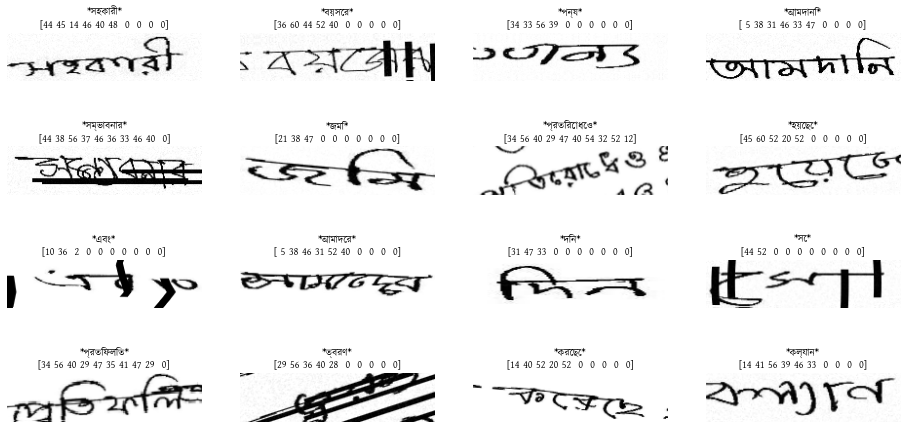

In [ ]:
# from PIL import ImageFont
prop = fm.FontProperties(fname='./kalpurush.ttf')
_, ax = plt.subplots(4, 4, figsize=(16, 8))
for data in DataGen(x_train, y_train, True, p=1):
    #images, texts = batch
    img, texts = data["image"], data["txt"]
    print(img.shape, texts.shape)
    print(texts)
    for i in range(16):
        txt = tf.strings.reduce_join(num_to_char(texts[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[i, :, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(f"*{txt}*\n{texts[i]}", fontproperties=prop)
        ax[i // 4, i % 4].axis("off")
    break
 
plt.show()

In [ ]:
# Choose any of these models
test_models = ['VGG16', 'VGG19', 'Xception', 'ResNet50', 'ResNet101', 
               'ResNet152', 'ResNet50V2', 'ResNet101V2', 'ResNet152V2', 
               'InceptionV3', 'InceptionResNetV2', 'MobileNet', 'MobileNetV2',
               'DenseNet121', 'DenseNet169', 'DenseNet201']
 
# WORKS WITH ANY MODEL, just put the layer_name
def CustomNetwork(model_name, layer_name=None, 
                  input_shape=(img_width, img_height, 3),
                  add_activation=False):
    
    tf.keras.backend.clear_session()
    inp = layers.Input(input_shape)
    model_str = model_name + "(input_tensor=inp, include_top=False, weights='imagenet')"
    base_model = eval(model_str)
 
    if layer_name == None:
        return base_model
    
    out = base_model.get_layer(layer_name).output
    if add_activation:
        out = layers.ReLU()(out)
 
    return keras.models.Model(inp, out, name=f"{model_name}")
 
 
# Uncomment these lines to see the model
 
baseline_name = "DenseNet121"
layer_name = {
    "MobileNet": "conv_pw_5_relu",
    "DenseNet121": "pool3_conv",
    "Xception": "block4_sepconv2",
    "NASNetMobile":"activation_71",
}
 
baseline = CustomNetwork(baseline_name, layer_name[baseline_name], 
                         add_activation=False)
# plot_model(CustomNetwork('NASNetMobile', None), to_file='model_plot.pdf', show_shapes=True, 
          #  show_layer_names=True, expand_nested=False)
baseline.summary()

Model: "DenseNet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 50, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 56, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 100, 25, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 100, 25, 64)  256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
#CustomNetwork('NASNetMobile', 'activation_72').summary()

In [ ]:
train_dataset = DataGen(x_train, y_train, augment=True, p=0.65)
validation_dataset = DataGen(x_valid, y_valid, augment=False)
test_dataset = DataGen(x_test, y_test, augment=False)

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        #self.acc = tf.keras.metrics.Accuracy()
 
    #def on_epoch_end(self):
    #    self.acc.reset_states()
 
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
 
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
 
        # Adding loss
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
 
        # Adding char error
        #pred_val = tf.cast(tf.sparse.from_dense(tf.argmax(y_pred, axis=-1)), dtype=tf.int32)
        #true_val = tf.cast(tf.sparse.from_dense(y_true), dtype=tf.int32)
 
        #char_err = tf.edit_distance(pred_val, true_val, normalize=False)
        #self.add_metric(char_err, name='CER')
        #char_err = tf.edit_distance(pred_val, true_val, normalize=True)
        #self.add_metric(char_err, name='T_CER_norm')
        #char_err = tf.edit_distance(true_val, pred_val, normalize=True)
        #self.add_metric(char_err, name='P_CER_norm')
 
        #pred_without_zeros = tf.sparse.retain(pred_val, tf.not_equal(pred_val.values, 0))
        #true_without_zeros = tf.sparse.retain(true_val, tf.not_equal(true_val.values, 0))
        #char_err = tf.edit_distance(pred_without_zeros, true_without_zeros, normalize=True)
        #self.add_metric(char_err, name='NZ_CER')
 
        #self.acc.update_state(tf.sparse.to_dense(true_without_zeros), 
        #                      tf.sparse.to_dense(pred_without_zeros))
        #self.add_metric(self.acc.result(), name='ACC')
 
        #print(pred_without_zeros)
        # At test time, just return the computed predictions
        return y_pred
 
## 
# Choose from two different rnn variation: [LSTM, GRU] 

def build_model(baseline_name, rnn="LSTM"):
    if rnn not in ["LSTM", "GRU"]:
        raise ValueError("INVALID RNN TYPE")

    # Image input to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 3), name="image", dtype="float32"
    )
 
    base = CustomNetwork(baseline_name, layer_name[baseline_name], 
                         add_activation=False)
    x = base(input_img)
    
    print('pass 3', x.shape)
    _, w, h, c = x.shape
    x = layers.Reshape(target_shape=(w, h*c), name="reshape")(x)
 
    # Removing the last "Channel" axis
    #x = keras.backend.squeeze(x, axis=-1)
 
    # Text input to the model
    texts = layers.Input(name="txt", shape=(None,), dtype="float32")
 
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    #new_shape = ((img_width // 4), (img_height // 4) * 64)
    #x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    #x = layers.Dense(64, activation="relu", name="dense1")(x)
    #x = layers.Dropout(0.2)(x)
 
    # RNNs
    # The input shape must be (None, height, width)
    print("Bidirectional layer input shape", x.shape)

    if rnn == "LSTM":
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1,
                                          name="LSTM1"), name="BD1")(x)
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1,
                                          name="LSTM2"), name="BD2")(x)
    else:
        x = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.1,
                                          name="GRU1"))(x)
        x = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.1,
                                          name="GRU2"))(x)
 
    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary())+1, 
                     activation="softmax", name="dense2",
                     use_bias=True)(x)
 
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(texts, x)
 
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, texts], outputs=output, name=f"ocr_{base.name}_{rnn}",
        #inputs=base.input, outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model
 
# Get the model
model = build_model("DenseNet121", "LSTM")
model.summary()

pass 3 (None, 25, 6, 256)
Bidirectional layer input shape (None, 25, 1536)
Model: "ocr_DenseNet121_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 3)] 0                                            
__________________________________________________________________________________________________
DenseNet121 (Functional)        (None, 25, 6, 256)   1444928     image[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 25, 1536)     0           DenseNet121[0][0]                
__________________________________________________________________________________________________
BD1 (Bidirectional)             (None, 25, 128)      819712      reshape[0][0]                    
____

In [ ]:
#build_model("NASNetMobile", "GRU").summary()

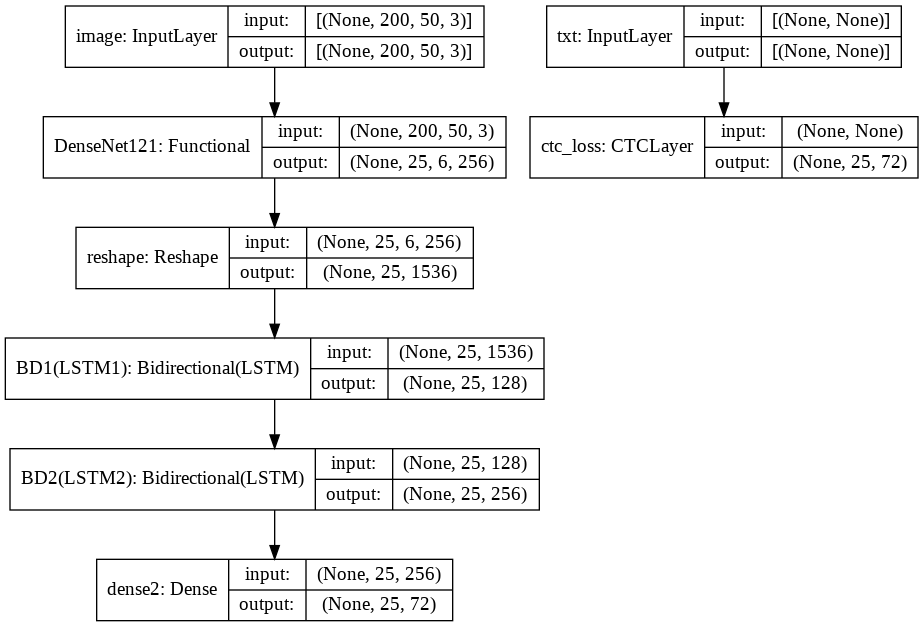

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, 
           show_layer_names=True, expand_nested=False)

In [ ]:
history = model.fit(
        DataGen(x_train, y_train, True, p=1),
        epochs=1,
    )

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


742/742 [==============================] - 200s 214ms/step - loss: 22.0879


In [ ]:
def load_submodel(model_dir, lmodel):
    cnt = 0
    temp_model = tf.keras.models.load_model(model_dir)
    for i, layer in enumerate(temp_model.layers):
        try:
            lmodel.get_layer(layer.name).set_weights(layer.get_weights())
            print('Layer:', layer.name)
            cnt += 1
        except:
            continue
    print(f"{cnt} layer weights loaded")

#load_submodel('./OCR_v2/ocr_MobileNet_GRU/',
#              model)

In [ ]:
class SaveLog(tf.keras.callbacks.Callback):
    '''
        save_path:     Destination where the model weights are saved.

        save_weights:  True ensures only the wights are saved. Setting to False
                       saves the model weights and network definitions.
        
        save_on_epoch: Integer declaring the number of epoches after the model 
                       is saved.
                        -1: saved if maximum accuracy is found
                        0 : saved on every epoch
                        n > 0: saved after n epochs

        load_prev:     If True, the callback loads the previous model weights 
                       and logs
        
        monitor:       On which metric the logger should depend on

        patience:      Number of epochs with no improvement after which 
                       training will be stopped.

        mode:          One of `{"auto", "min", "max"}`. In `min` mode,
                       training will stop when the quantity monitored has 
                       stopped decreasing; in `"max"` mode it will stop when 
                       the quantity monitored has stopped increasing; 
                       in `"auto"` mode, the direction is automatically 
                       inferred from the name of the monitored quantity.

        save_best_model: If true, the logger saves a different copy of the model
                         with the best value of the monitored quantity.

        restore_best_weights:  Whether to restore model weights from the epoch 
                               with the best value of the monitored quantity. 
                               If False, the model weights obtained at the last 
                               step of training are used.
    '''

    def __init__(self, save_path='./log/', 
                 save_on_epoch=-1, monitor='loss', mode='auto', 
                 load_prev=False, patience=5, save_best_model=True,
                 restore_best_weights=True,
                 verbose=True):
        
        self.os  = __import__('os')
        self.pkl = __import__('pickle')
        self.np = __import__('numpy')
        self.tf = __import__('tensorflow')
        self.tf.get_logger().setLevel('ERROR')
        super(SaveLog, self).__init__() 
        
        self.save_on_epoch = save_on_epoch
        if save_on_epoch < -1:
            raise ValueError("Invalid 'save_on_epoch' value." 
                             " Should be greater than -1.")

        self.monitor = monitor
        self.save_dir = None
        self.log_dir = None
        self.save_best_model = save_best_model
        self.patience = patience
        self.patience_kept = 0
        self.logs = {}
        self.load_prev = load_prev
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        
        if mode == 'min':
            self.monitor_op = self.np.less
            self.metric_val = self.np.inf
            self.mode = 'min'
        elif mode == 'max':
            self.monitor_op = self.np.greater
            self.metric_val = -self.np.inf
            self.mode = 'max'
        else:
            if 'acc' in self.monitor:
                self.monitor_op = self.np.greater
                self.metric_val = -self.np.inf
                self.mode = 'max'
            else:
                self.monitor_op = self.np.less
                self.metric_val = self.np.inf
                self.mode = 'min'


    def _save_model(self, best=False):
        sdir = self.best_dir if best else self.save_dir
        if best:
            self.model.save_weights(sdir)
        else:
            self.model.save(sdir, overwrite=True)
        #if self.verbose: 
        print(f'{"Best m" if best else "M"}odel saved on {sdir}')  


    def _load_model(self):
        try:
            self.model.load_weights(self.save_dir)
            if self.verbose: print('Weights loaded')
            return
        except:
            pass
        try:
            cnt = 0
            temp_model = self.tf.keras.models.load_model(self.save_dir)
            for i, layer in enumerate(temp_model.layers):
                try:
                    self.model.get_layer(layer.name).set_weights(layer.get_weights())
                    cnt += 1
                except:
                    continue
            if self.verbose: print(f"{cnt} layer weights loaded")
        except:
            pass


    def _save_logs(self, epoch):
        with open(self.log_dir, 'wb') as f:
            self.pkl.dump(self.logs, f)
        if self.verbose: print(f'Logs saved on epoch {epoch+1}')


    def _load_logs(self):
        try:
            with open(self.log_dir, 'rb') as f:
                log = self.pkl.load(f)
            if self.mode == 'max':
                self.metric_val = max(log[self.monitor])
            else:
                self.metric_val = min(log[self.monitor])
            if self.verbose: print(f'Logs loaded, best {self.monitor}: {self.metric_val:.5f}')
            return log
        except:
            return {}


    def _saver(self, epoch, logs):
        log_val = logs[self.monitor]
        if self.save_on_epoch == 0:
            self._save_logs(epoch)
            self._save_model()

            if self.save_best_model and self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                self._save_model(best=True)

        elif self.save_on_epoch == -1:
            if self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                if self.verbose: print('Minimum loss found')
                self._save_logs(epoch)
                if self.save_best_model:
                    self._save_model(best=True)
        else:
            if epoch % self.save_on_epoch == 0:
                self._save_logs(epoch)
                self._save_model()
            
            if self.save_best_model and self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                self._save_model(best=True)
                

    def on_train_begin(self, logs=None):
        self.save_dir = self.os.path.join(self.save_path, self.model.name, '')
        self.best_dir = self.os.path.join(self.save_dir, 'best_weight.h5')
        self.log_dir = self.os.path.join(self.save_dir, 'train_log.pkl')
         
        if self.verbose: print('SavePath', self.save_dir)
        if not self.os.path.exists(self.save_dir):
            self.os.makedirs(self.save_dir)
            if self.verbose: print('New directory created')
        elif self.load_prev:
            self._load_model()
            self.logs = self._load_logs() or {}


    def on_epoch_end(self, epoch, logs=None):
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)
        
        if self.patience != None:
            if self.monitor_op(logs[self.monitor], self.metric_val):
                self.patience_kept = 0
            else:
                self.patience_kept += 1
            if self.patience_kept > self.patience:
                self.model.stop_training = True
                if self.verbose: print("Stopping training")
                if self.restore_best_weights:
                    if self.verbose: print("Restoring best weights")
                    self.model.load_weights(self.best_dir)
        
        self._saver(epoch, logs)

epochs = 1000
early_stopping_patience = 10

#logger = SaveLog(save_path='./OCR_v2', monitor='val_loss', 
#                 save_on_epoch=5, patience=early_stopping_patience, 
#                 verbose=True, load_prev=True)
#print(model.name)

In [ ]:
'''

The models are available in the following link. 

https://drive.google.com/file/d/1atCb_it69GP72PghG-MMDbua70F2XG1h/view?usp=sharing

You need to download and extract.

'''


dirs = ['./OCR_v2/ocr_NASNetMobile_GRU',
        './OCR_v2/ocr_NASNetMobile_LSTM',
        './OCR_v2/ocr_DenseNet121_GRU',
        './OCR_v2/ocr_DenseNet121_LSTM',
        './OCR_v2/ocr_MobileNet_LSTM',
        './OCR_v2/ocr_MobileNet_GRU',
        './OCR_v2/ocr_Xception_LSTM',
        './OCR_v2/ocr_Xception_GRU']

def get_flops(model_h5_path):
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops


for d in dirs[2:]:
    print(d.split('/')[-1], ":", get_flops(d))

In [ ]:
# Train the model
for baseline in list(layer_name.keys())[3:]:
    model = build_model(baseline, "GRU")
    #load_submodel(f'./OCR_v2/ocr_{baseline}_LSTM/', model)
 
    logger = SaveLog(save_path='./OCR_v2', monitor='val_loss', 
                    save_on_epoch=5, patience=early_stopping_patience, 
                    verbose=False, load_prev=True)
    
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        verbose=0,
        callbacks=[logger],
        max_queue_size=20,
    )
 
    #========================================
 
    model = build_model(baseline, "LSTM")
    #load_submodel(f'./OCR_v2/ocr_{baseline}_LSTM/', model)
 
    logger = SaveLog(save_path='./OCR_v2', monitor='val_loss', 
                    save_on_epoch=5, patience=early_stopping_patience, 
                    verbose=False, load_prev=True)
    
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        verbose=0,
        callbacks=[logger],
        max_queue_size=20,
    )

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
#dirs = ['./OCR/ocr_DenseNet121_GRU_best',
#        './OCR/ocr_DenseNet121_LSTM_best',
#        './OCR/ocr_MobileNet_LSTM_best',
#        './OCR/ocr_MobileNet_GRU_best',
#        './OCR/ocr_Xception_LSTM_best',
#        './OCR/ocr_Xception_GRU_best']
 
dirs = ['./OCR_v2/ocr_NASNetMobile_GRU',
        './OCR_v2/ocr_NASNetMobile_LSTM',
        './OCR_v2/ocr_DenseNet121_GRU',
        './OCR_v2/ocr_DenseNet121_LSTM',
        './OCR_v2/ocr_MobileNet_LSTM',
        './OCR_v2/ocr_MobileNet_GRU',]
        #'./OCR_v2/ocr_Xception_LSTM_best',
        #'./OCR_v2/ocr_Xception_GRU_best']
 
 
for ldir in dirs[:2]:
    tmodel = tf.keras.models.load_model(ldir)
    data_order = ["Train", "Validation", "Test"]
    tmodel.load_weights(os.path.join(ldir, 'best_weight.h5'))
 
    print()
    print(ldir.split('/')[-1])
    print('='*25)
    print()
 
    prediction_model = keras.models.Model(
        tmodel.get_layer(name="image").input, tmodel.get_layer(name="dense2").output
    )
 
    ret = tmodel.evaluate(train_dataset, verbose=0)
    print('Train loss:', ret)
    ret = tmodel.evaluate(validation_dataset, verbose=0)
    print('Validation loss:', ret)
    ret = tmodel.evaluate(test_dataset, verbose=0)
    print('Test: loss', ret)
 
    for i, (xxx, yyy) in enumerate([(x_train, y_train), 
                                (x_valid, y_valid), 
                                (x_test, y_test)]):
        TOT = xxx.shape[0]
        TOTC, WAC, CE = 0, 0, 0
 
        print(f"Calculating on {data_order[i]} data")
 
        for batch in DataGen(xxx, yyy, augment=False, batch_size=16):
            batch_images = batch["image"]
            batch_texts = batch["txt"]
        
            preds = prediction_model.predict(batch_images)
            pred_texts = decode_batch_predictions(preds)
        
            orig_texts = []
            for txt in batch_texts:
                txt = tf.strings.reduce_join(num_to_char(txt)).numpy().decode("utf-8")
                orig_texts.append(txt)
        
            for i in range(min(len(pred_texts), 16)):
                if pred_texts[i] == orig_texts[i]:
                    WAC += 1
                CE += nltk.edit_distance(pred_texts[i], orig_texts[i], 
                                        transpositions=True)
                TOTC += len(orig_texts[i])
                
 
        #print(f"Total: {TOT}, Accurate: {WAC}, WER: {(TOT-WAC)/TOT},"
        #    f"CER: {CE/TOTC}")
 
        print(f"CER: {CE/TOTC},"
              f"WER: {(TOT-WAC)/TOT}")




Train loss: 3.979869842529297
Validation loss: 4.628052711486816
Test: loss 4.601612567901611
Calculating on Train data
CER: 0.04525584983286192,WER: 0.17118330247433092
Calculating on Validation data
CER: 0.15879551142326634,WER: 0.4018067556952082
Calculating on Test data
CER: 0.1605146763168476,WER: 0.40361209265802905



Train loss: 3.8704757690429688
Validation loss: 5.176077365875244
Test: loss 5.319347381591797
Calculating on Train data
CER: 0.03975246845858475,WER: 0.14155866015822252
Calculating on Validation data
CER: 0.17738681300944234,WER: 0.4096622152395915
Calculating on Test data
CER: 0.1893239006350993,WER: 0.4259913623871221


In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    tmodel.get_layer(name="image").input, tmodel.get_layer(name="dense2").output
)
#prediction_model.summary()
 
#  Let's check results on some validation samples
prop = fm.FontProperties(fname='./kalpurush.ttf')
 
for batch in DataGen(x_test, y_test, augment=False):
    batch_images = batch["image"]
    batch_texts = batch["txt"]
 
    print(len(batch_images), "images")
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
 
    orig_texts = []
    for txt in batch_texts:
        txt = tf.strings.reduce_join(num_to_char(txt)).numpy().decode("utf-8")
        orig_texts.append(txt)
    _, ax = plt.subplots(4, 4, figsize=(16, 7))
 
    for i in range(min(len(pred_texts), 16)):
        img = ((batch_images[i, :, :, 0]))
        img = img.T
        ttext = tf.strings.reduce_join(num_to_char(batch_texts[i])).numpy().decode("utf-8")
        title = f"True:{ttext}\nPrediction:{pred_texts[i]}\n{np.argmax(preds[i], axis=-1)[:10]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title, fontproperties=prop, color="white")
        ax[i // 4, i % 4].axis("off")
    break
 
plt.tight_layout()
plt.show()

In [ ]:
print(len(char_to_num.get_vocabulary()))
print(char_to_num.get_vocabulary())
print(char_to_num.get_config())
print(char_to_num.get_weights())